In [1]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.core import read, Stream
import pandas as pd

In [2]:
path = '/Users/sydneydybing/SW4/strain/usgs_rc-results/'
path2 = '/Users/sydneydybing/SW4/strain/M7_RC-results/'
stas = ['B072', 'B079', 'B082', 'B087', 'B916', 'B917', 'B918', 'B921']
test_stas = ['B917']

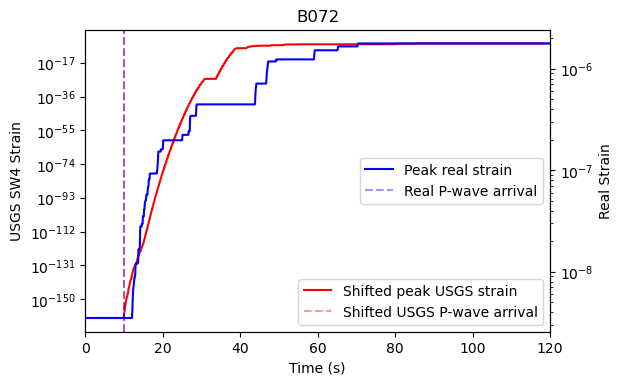

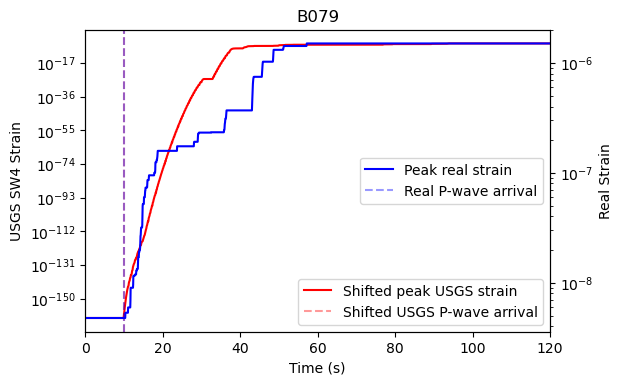

No real RMS strain data available for station B082


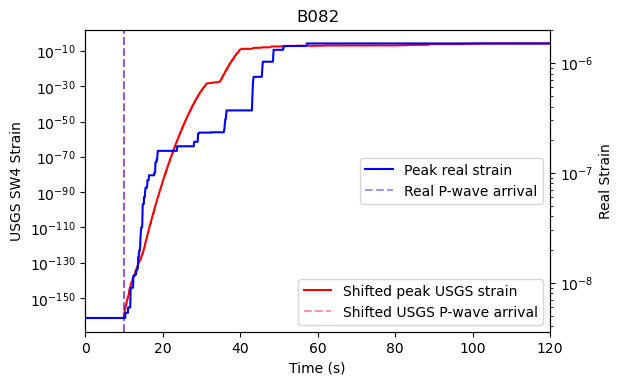

No real RMS strain data available for station B087


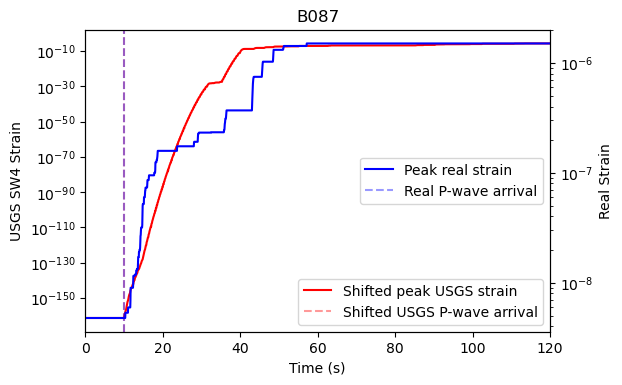

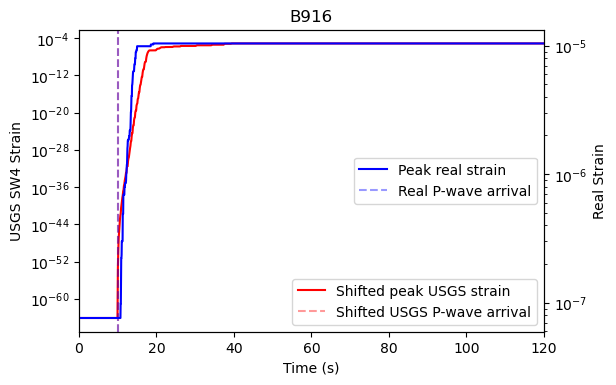

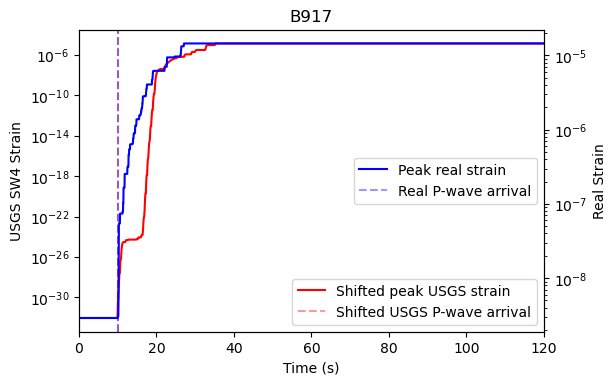

No real RMS strain data available for station B918


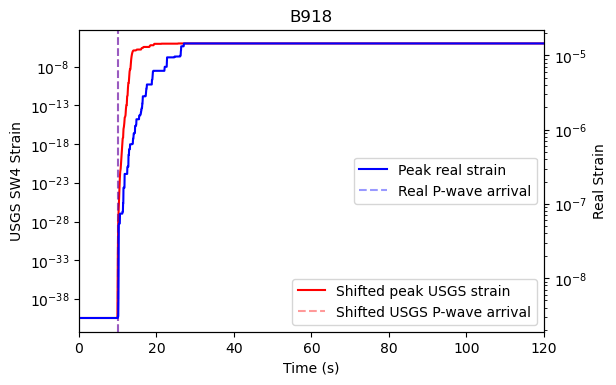

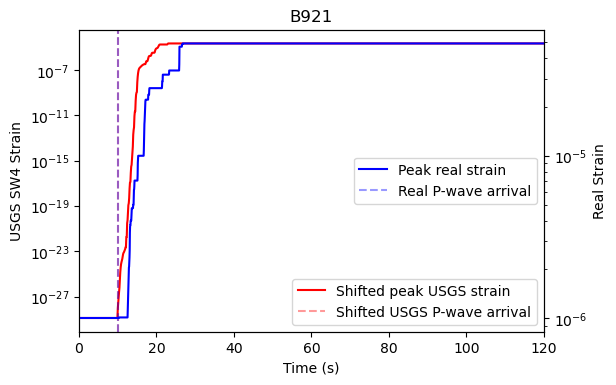

In [54]:
for sta in stas:
    
    strain_usgs = pd.read_csv(path + sta + '.txt', sep = '\s+', skiprows = 16, names = ['time', 'xx', 'yy', 'zz', 'xy', 'xz', 'yz'])
    strain_fq = pd.read_csv(path2 + sta + '.txt', sep = '\s+', skiprows = 16, names = ['time', 'xx', 'yy', 'zz', 'xy', 'xz', 'yz'])
    
    xx_usgs = strain_usgs.xx.values
    xy_usgs = strain_usgs.xy.values
    yy_usgs = strain_usgs.yy.values

    rms_usgs = np.sqrt((xx_usgs**2 + xy_usgs**2 + yy_usgs**2)/3)

    xx_fq = strain_fq.xx.values
    xy_fq = strain_fq.xy.values
    yy_fq = strain_fq.yy.values

    rms_fq = np.sqrt((xx_fq**2 + xy_fq**2 + yy_fq**2)/3)
    
    try:
        i_usgs = np.where(rms_usgs > 0)[0]
        p_arr_idx_usgs = i_usgs[0]
        i_fq = np.where(rms_fq > 0)[0]
        p_arr_idx_fq = i_fq[0]
        
    except: 
        print(sta + ': no strain yet')
        continue # skips to next station if all the strain at this station is zeros
    
    # RMS USGS strain calculation
    rms_strain_usgs = rms_usgs
    rms_times_usgs = strain_usgs.time.values
    
    mod_rms_strain_usgs = rms_strain_usgs.copy()
    mod_rms_times_usgs = rms_times_usgs.copy()
    
    p_arr_strain_usgs = rms_strain_usgs[p_arr_idx_usgs]
    
    mod_rms_strain_usgs[:p_arr_idx_usgs] = p_arr_strain_usgs
    
    pst_strain_usgs = mod_rms_strain_usgs.copy()
    pst_times_usgs = mod_rms_times_usgs.copy()
    
    # Loop over samples
    for k in range(0,len(mod_rms_strain_usgs)): #avoid starting at zero

        if k == 0:
            strain = mod_rms_strain_usgs[0]
            max_strain = strain

        else:
            # Grab progressively longer windows and save the biggest strain
            strain = mod_rms_strain_usgs[:k+1] # Has to be k+1 because slicing doesn't include last one
            max_strain = max(strain)

        # Put peak strain back into the output stream
        pst_strain_usgs[k] = max_strain 
    
    current_p_time = pst_times_usgs[p_arr_idx_usgs]
    sampling_rate = len(pst_times_usgs) / max(pst_times_usgs)
    needs_to_move_secs = 10 - current_p_time
    samples_to_move = int(needs_to_move_secs * sampling_rate)
    strain_fill_to_add = np.full((samples_to_move,), fill_value = p_arr_strain_usgs)
    new_pst_strain_usgs = np.insert(pst_strain_usgs, 0, strain_fill_to_add)
    new_pst_times_usgs = np.arange(0, max(pst_times_usgs)+needs_to_move_secs, step = (max(pst_times_usgs)+needs_to_move_secs)/len(new_pst_strain_usgs))
    
#     print(pst_times_usgs.shape)
#     print(pst_strain_usgs.shape)
#     print(new_pst_times_usgs.shape)
#     print(new_pst_strain_usgs.shape)
    
    # Add in real Ridgecrest strain data for these stations to further compare
    real_path = '/Users/sydneydybing/StrainProject/2024/strain_data/peak_post_p/2019-07-06_M7.1/'
   
    try:
        real_peak_strain = read(real_path + sta + '.mseed')
        real_ps_data = real_peak_strain[0].data
        real_ps_times = real_peak_strain[0].times()
    except:
        print('No real RMS strain data available for station ' + str(sta))
    
    # Make plot
    fig = plt.figure(dpi = 100)
    ax = fig.add_subplot(111)
    ax.set_title(sta)
    
#     ax.plot(strain_usgs.time.values, xx_usgs, label = 'USGS xx', color = 'blue')
#     ax.plot(strain_usgs.time.values, xy_usgs, label = 'USGS xy', color = 'orange')
#     ax.plot(strain_usgs.time.values, yy_usgs, label = 'USGS yy', color = 'green')

#     ax2 = ax.twinx()
#     ax.plot(strain_fq.time.values, xx_fq, label = 'FQ xx', color = 'blue', linestyle = '--', alpha = 0.5)
#     ax.plot(strain_fq.time.values, xy_fq, label = 'FQ xy', color = 'orange', linestyle = '--')
#     ax.plot(strain_fq.time.values, yy_fq, label = 'FQ yy', color = 'green', linestyle = '--')

#     ax.plot(rms_times_usgs, rms_strain_usgs, color = 'green', label = 'RMS USGS strain')
#     ax.plot(mod_rms_times_usgs, mod_rms_strain_usgs, color = 'blue', label = 'RMS USGS strain')
#     ax.plot(pst_times_usgs, pst_strain_usgs, color = 'red', label = 'Peak USGS strain')
    ax.plot(new_pst_times_usgs, new_pst_strain_usgs, color = 'red', label = 'Shifted peak USGS strain')

#     ax.plot(rms_times_fq, rms_strain_fq, color = 'green', label = 'RMS FQ strain', linestyle = '--')
#     ax.plot(mod_rms_times_fq, mod_rms_strain_fq, color = 'blue', label = 'RMS FQ strain', linestyle = '--')
#     ax.plot(pst_times_fq, pst_strain_fq, color = 'red', label = 'Peak FQ strain', linestyle = '--')

    ax.semilogy()
    
    ax2 = ax.twinx()
    ax2.plot(real_ps_times, real_ps_data, color = 'blue', label = 'Peak real strain')
    ax2.axvline(10, color = 'blue', alpha = 0.4, linestyle = '--', label = 'Real P-wave arrival')
    ax2.semilogy()
    ax2.set_ylabel('Real Strain')
    ax2.legend(loc = 'center right')

    value = new_pst_strain_usgs[0]
    i = np.where(new_pst_strain_usgs != value)[0]
#     ax.axvline(rms_times_usgs[i_usgs[0]], color = 'red', alpha = 0.4, linestyle = '--', label = 'USGS P-wave arrival')
    ax.axvline(new_pst_times_usgs[i][0], color = 'red', alpha = 0.4, linestyle = '--', label = 'Shifted USGS P-wave arrival')
#     ax.axvline(rms_times_fq[i_fq[0]], color = 'skyblue', linestyle = '--', label = 'FQ P-wave arrival')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('USGS SW4 Strain')
#     ax.set_xlim(0, strain_fq.time.values[:int(len(strain_fq.time.values)/2)][-1])
    ax.set_xlim(0, 120)
#     ax.set_ylim(min(xx_fq[:int(len(xx_fq)/2)])*1.1, max(xx_fq[:int(len(xx_fq)/2)])*1.1)
#     plt.ylim(10**-15, 10**-3)
    ax.legend(loc = 'lower right')
#     ax2.legend()

    plt.show()


In [45]:
value = new_pst_strain_usgs[0]
i = np.where(new_pst_strain_usgs != value)[0]
print(i)
print(new_pst_times_usgs[i][0])

[  96   97   98 ..., 1238 1239 1240]
9.28283642224


In [20]:
print(max(pst_times_usgs))

120.0


In [21]:
print(len(pst_times_usgs))

1148


In [22]:
sampling_rate = len(pst_times_usgs) / max(pst_times_usgs)
print(sampling_rate)

9.56666666667


In [23]:
current_p_time = pst_times_usgs[p_arr_idx_usgs]
print(current_p_time)

0.2092415


In [25]:
needs_to_move_secs = 10 - current_p_time
print(needs_to_move_secs)

9.7907585


In [27]:
samples_to_move = int(needs_to_move_secs * sampling_rate)
print(samples_to_move)

93


In [37]:
strain_fill_to_add = np.full((samples_to_move,), fill_value = p_arr_strain_usgs)
print(strain_fill_to_add)

[  9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33   9.19499011e-33   9.19499011e-33
   9.19499011e-33   9.19499011e-33

In [32]:
print(len(pst_times_usgs))

1148


In [33]:
new_times_array = np.insert(pst_times_usgs, 0, strain_fill_to_add)
print(len(new_times_array))

1241
